# CIFAR10 Classifier - Softmax loss

### Import packages

In [1]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

### Load and normalize CIFAR10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### NEURAL NETWORK WITH SOFTMAX FUNCTION

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Optimizer

In [4]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## T-softmax and cross entropy loss function

In [6]:
'''
Based on: 
https://zhang-yang.medium.com/understanding-cross-entropy-implementation-in-pytorch-softmax-log-softmax-nll-cross-entropy-416a2b200e34
'''

def T_softmax(x,T): 
    '''
    x - output from neural network,
    T - temperature parameter.
    '''
    x_T = x/T
    return x_T.exp() / x_T.exp().sum(-1)

def ce(input, target): 
    '''
    Negative logarithm of softmax values.
    '''
    log_prob = -1.0 * input.log()
    loss = log_prob.gather(1,target.unsqueeze(1))
    loss = loss.mean()
    return loss


### Training network

In [7]:
import torch.optim as optim
T = 0.3
epochs = 10
for e in range(epochs):
  running_loss = 0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    pred = T_softmax(outputs, T)
    loss = ce(pred, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 4000 == 3999:    # print every 4000 mini-batches
        print(f'[{e + 1}, {i + 1:5d}] loss: {running_loss / 4000:.3f}')
        running_loss = 0.0

print('Finished Training')

/mnt/data/klaszewski/miniconda3/envs/nn_proj/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 101: invalid device ordinal (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


[1,  4000] loss: 2.113
[1,  8000] loss: 1.890
[1, 12000] loss: 1.847
[1, 16000] loss: 1.801
[1, 20000] loss: 1.813
[1, 24000] loss: 1.773
[1, 28000] loss: 1.815
[1, 32000] loss: 1.809
[1, 36000] loss: 1.802
[1, 40000] loss: 1.765
[1, 44000] loss: 1.778
[1, 48000] loss: 1.814
[2,  4000] loss: 1.766
[2,  8000] loss: 1.786
[2, 12000] loss: 1.766
[2, 16000] loss: 1.822
[2, 20000] loss: 1.811
[2, 24000] loss: 1.775
[2, 28000] loss: 1.790
[2, 32000] loss: 1.784
[2, 36000] loss: 1.808
[2, 40000] loss: 1.808
[2, 44000] loss: 1.812
[2, 48000] loss: 1.792
[3,  4000] loss: 1.792
[3,  8000] loss: 1.769
[3, 12000] loss: 1.813
[3, 16000] loss: 1.811
[3, 20000] loss: 1.797
[3, 24000] loss: 1.777
[3, 28000] loss: 1.851
[3, 32000] loss: 1.810
[3, 36000] loss: 1.817
[3, 40000] loss: 1.832
[3, 44000] loss: 1.772
[3, 48000] loss: 1.772
[4,  4000] loss: 1.865
[4,  8000] loss: 1.825
[4, 12000] loss: 1.840
[4, 16000] loss: 1.824
[4, 20000] loss: 1.809
[4, 24000] loss: 1.793
[4, 28000] loss: 1.781
[4, 32000] 

### Test network on dataset

In [8]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 32 %


### Predictions for each class

In [9]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 74.2 %
Accuracy for class: car   is 73.4 %
Accuracy for class: bird  is 54.5 %
Accuracy for class: cat   is 34.7 %
Accuracy for class: deer  is 55.9 %
Accuracy for class: dog   is 50.9 %
Accuracy for class: frog  is 71.8 %
Accuracy for class: horse is 72.5 %
Accuracy for class: ship  is 70.5 %
Accuracy for class: truck is 71.5 %


In [9]:
vector = []
for i, data in enumerate(testloader):
    images, labels = data
    outputs1 = net(images)
    vector.append(outputs1[0].tolist())
    
vectors = np.array(vector)

In [10]:
label = []
for i, data in enumerate(testloader):
    images, labels = data
    label.append(labels[0].tolist())
    
labels_arr = np.array(label)

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)

embs = tsne.fit_transform(vectors)

/mnt/data/klaszewski/miniconda3/envs/nn_proj/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/data/klaszewski/miniconda3/envs/nn_proj/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.758949
[t-SNE] KL divergence after 1000 iterations: 0.945072


In [12]:
import pandas as pd
df = pd.DataFrame()
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]
df['label'] = labels_arr

In [13]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
c_labels = []
for i, data in enumerate(labels_arr):
    c_labels.append(classes[labels_arr[i]])

df['label'] = c_labels

# TSNE Visualization for T = 50, l-r = 0.001

[Text(0.5, 1.0, 'CIFAR10 data T-SNE projection, T = 0.3, lr = 0.001')]

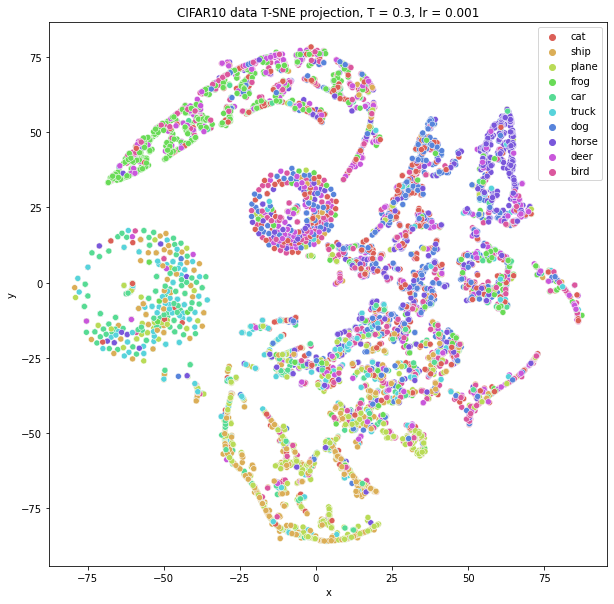

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 0.3, lr = 0.001")

# TSNE Visualization for T = 50, l-r = 0.001

[Text(0.5, 1.0, 'CIFAR10 data T-SNE projection, T = 50, lr = 0.001')]

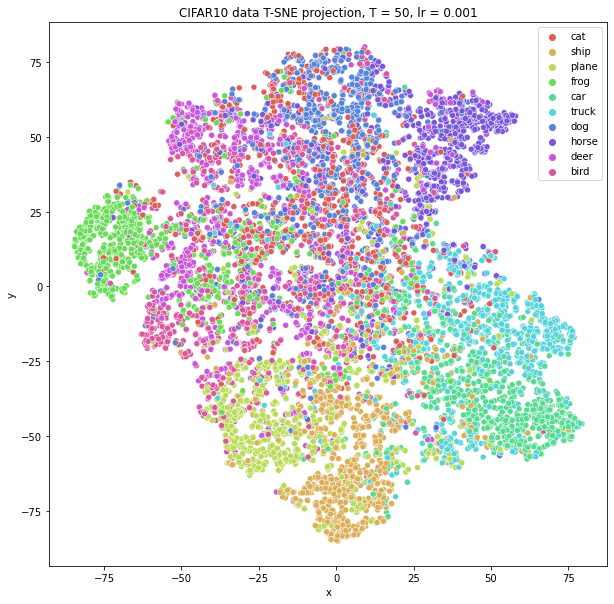

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 50, lr = 0.001")

(<Figure size 1080x864 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-15.86914, -42.87582, '0'),
  Text(49.241528, -38.58701, '1'),
  Text(-28.289371, -0.6109921, '2'),
  Text(-5.6511545, 22.080223, '3'),
  Text(-29.795668, 22.774998, '4'),
  Text(-1.9322131, 44.092827, '5'),
  Text(-59.883675, 12.263916, '6'),
  Text(30.502712, 45.80721, '7'),
  Text(3.6049328, -55.117035, '8'),
  Text(45.380123, -15.207699, '9')])

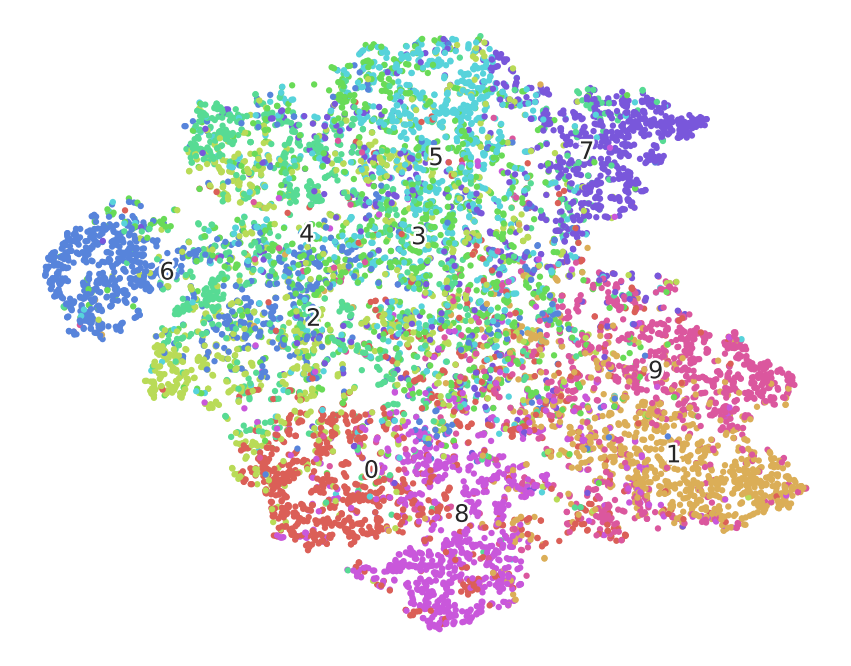

In [18]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

data = df.iloc[0:,:2]

fashion_scatter(data, labels_arr)

# TSNE Visualization for T = 25 and l-r = 0.001

[Text(0.5, 1.0, 'CIFAR10 data T-SNE projection, T = 25, lr = 0.001')]

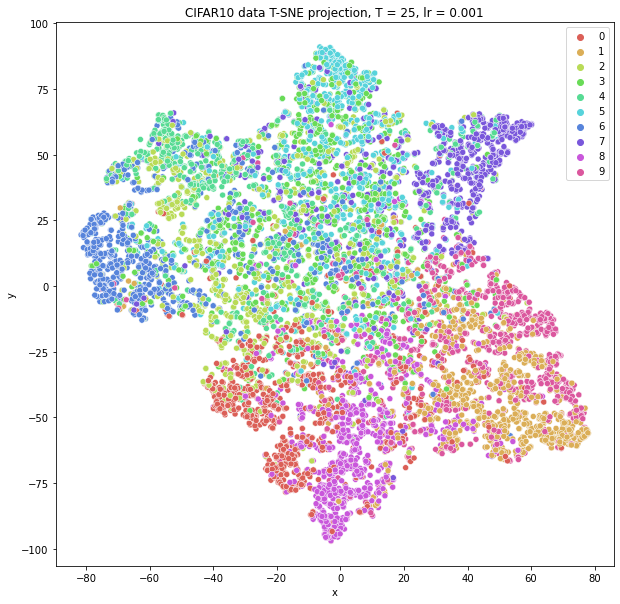

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 25, lr = 0.001")

# TSNE Visualization for T = 0.5 and l-r = 0.001

[Text(0.5, 1.0, 'CIFAR10 data T-SNE projection, T = 0.5, lr = 0.001')]

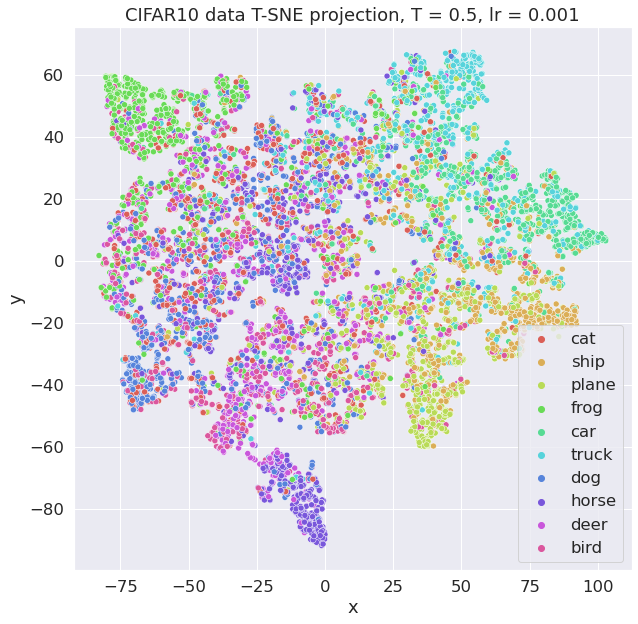

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 0.5, lr = 0.001")

# Plot with labels

In [17]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(15, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x.iloc[:,0], x.iloc[:,1], lw=0, s=40, c=palette[colors.astype(np.int64)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x.iloc[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 1080x864 with 1 Axes>,
 <AxesSubplot:>,
 [Text(34.849724, -21.584194, '0'),
  Text(56.3582, 19.515923, '1'),
  Text(-20.84556, -20.007502, '2'),
  Text(-29.046034, 5.3111763, '3'),
  Text(-27.144556, -9.204217, '4'),
  Text(-38.964928, -9.343994, '5'),
  Text(-54.459488, 38.51219, '6'),
  Text(-10.472607, -7.4693856, '7'),
  Text(48.741096, -14.360815, '8'),
  Text(41.573853, 30.841188, '9')])

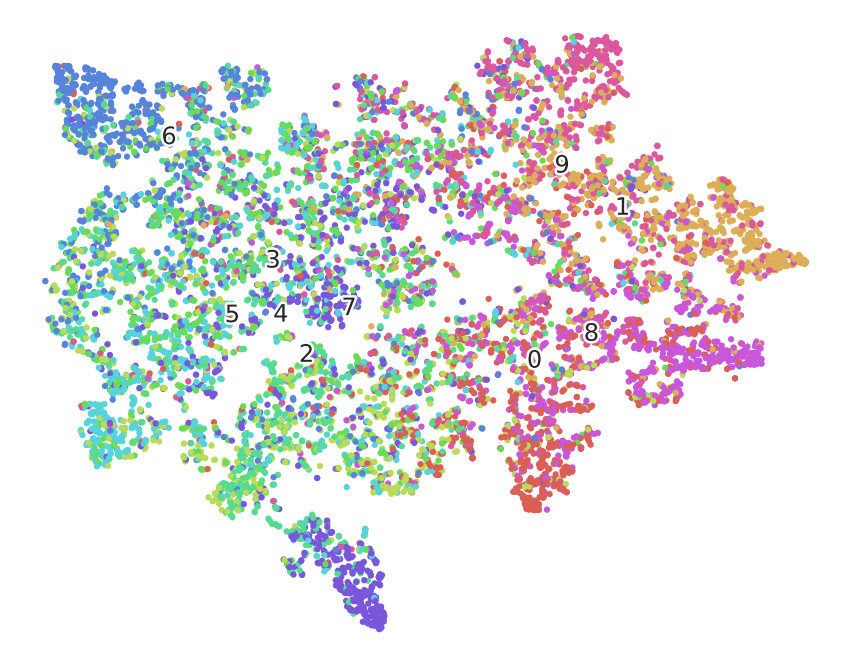

In [110]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

data = df.iloc[0:,:2]

fashion_scatter(data, labels_arr)